# Notebook 12 a) Aspect Prediction with Machine Learning Models

This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns using ML models. The output is therefore MULTICLASS.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing
* Section 3 - Run models
* Section 4 - Prediction on validation set
* Section 5 - Summary Tables
* Section 6 - Hyperparameter Tuning
* Section 7 - Best Model against the Test Set

Dataset:
* combinedaspectcheck.xlsx

# Section 1: Import libraries and data

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import SCORERS
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,balanced_accuracy_score, roc_auc_score,precision_score, recall_score, f1_score
import joblib
import pickle
import warnings
import random
random.seed(1)

In [254]:
df_accom = pd.read_excel('combinedaspectcheck.xlsx',sheet_name = 'CLEANEDACCOM')
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT")

In [255]:
df_accom.head()

,OrigInd,Category,Cleaned,Noun Phrases,Nouns,Aspect,Sentiment
0,2030,Accommodation,main complaint room made u feel ill,main complaint room,complaint room,Room,-0.2960
1,10751,Accommodation,weekend away staff great room clean shower goo...,great room,room,Room,0.6249
2,11247,Accommodation,great room breakfast fabulous central location,great room breakfast fabulous,room breakfast,Room,0.8176
3,21902,Accommodation,shower great size well toiletry clean towel pr...,clean towel,towel,Room,0.4019
4,22835,Accommodation,great bed breakfast stayed week encore guest h...,lovely clean room facility,room facility,Room,0.7579


# Section 2: Pre-processing

In [256]:
# Drop column
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

In [257]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [258]:
df_accom["Aspect"].value_counts()

Food             350
Hotel            350
Entertainment    350
Staff            350
Room             350
Value            250
Location         220
Name: Aspect, dtype: int64

In [259]:
df_food["Aspect"].value_counts()

Value            350
Menu Choice      350
Food Quality     350
Meal Exp         350
Visit Exp        350
Staff&Service    350
Name: Aspect, dtype: int64

In [260]:
df_attract["Aspect"].value_counts()

Nature           300
Activities       300
Amenities        300
VisitExp&Gen     250
Staff&Service    200
Value            150
History          150
Name: Aspect, dtype: int64

In [261]:
# Function to specify X and y
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [262]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


In [263]:
# Train, validation split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True)
    return X_train,X_val, X_test, y_train,y_val,y_test

In [264]:
# Run function for each category
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,X_test_attract,y_train_attract,y_val_attract,y_test_attract = train_test(X_attract,y_attract)

In [265]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)
print(X_train_attract.shape, X_val_attract.shape,X_test_attract.shape, y_train_attract.shape, y_val_attract.shape, y_test_attract.shape)

(1776,) (222,) (222,) (1776,) (222,) (222,)
(1680,) (210,) (210,) (1680,) (210,) (210,)
(1320,) (165,) (165,) (1320,) (165,) (165,)


In [266]:
y_train_accom.value_counts()

Food             280
Hotel            280
Entertainment    280
Staff            280
Room             280
Value            200
Location         176
Name: Aspect, dtype: int64

In [267]:
# TFIDF vectorizer function
def vec(X_train, X_val, X_test):
    vect = TfidfVectorizer(use_idf = True, max_df = 1.0, min_df = 1, stop_words = "english", 
                           ngram_range = (1,1),smooth_idf = True, norm = 'l2')
    vect.fit(X_train)
    X_train_tfidf = vect.transform(X_train)
    X_val_tfidf = vect.transform(X_val)
    X_test_tfidf = vect.transform(X_test)
    return vect, X_train_tfidf, X_val_tfidf, X_test_tfidf

In [268]:
# Run function
accom_vect,X_train_accom_tfidf, X_val_accom_tfidf, X_test_accom_tfidf = vec(X_train_accom, X_val_accom,X_test_accom)
food_vect, X_train_food_tfidf, X_val_food_tfidf, X_test_food_tfidf = vec(X_train_food, X_val_food, X_test_food)
attract_vect,X_train_attract_tfidf, X_val_attract_tfidf, X_test_attract_tfidf = vec(X_train_attract, X_val_attract,X_test_attract)

In [269]:
# Function to save tokenizer objects
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [447]:
# Save for use in combined model
save_tok('accom_tok.pickle',accom_vect)

In [271]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l, y_val_l, y_test_l

In [272]:
# Apply functions
y_train_accom_l, y_val_accom_l, y_test_accom_l = lab(y_train_accom, y_val_accom, y_test_accom)
y_train_food_l, y_val_food_l, y_test_food_l = lab(y_train_food, y_val_food, y_test_food)
y_train_attract_l, y_val_attract_l, y_test_attract_l = lab(y_train_attract, y_val_attract, y_test_attract)

In [273]:
X_train_accom_tfidf

<1776x787 sparse matrix of type '<class 'numpy.float64'>'
	with 3549 stored elements in Compressed Sparse Row format>

In [274]:
# Stratified K Fold
def strat(model, X_train,y_train,vector):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train,y_train, cv=kfold)
    mean = cv_results.mean()
    df = pd.DataFrame({vector:mean},index = [0])
    return df

# Section 3: Run models

In [453]:
# Define models - balanced as some imbalance in classes
clf1 = MultinomialNB()
clf2 = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced")
clf3 = RandomForestClassifier(class_weight = "balanced")
clf4 = SVC(decision_function_shape='ovr',class_weight = "balanced", probability = True)

In [276]:
# Define models and run cross-validation on the training set data only
ac1 = strat(clf1, X_train_accom_tfidf, y_train_accom_l,"NB")
f1 = strat(clf1, X_train_food_tfidf, y_train_food_l,"NB")
t1 = strat(clf1, X_train_attract_tfidf, y_train_attract_l,"NB")

ac2 = strat(clf2, X_train_accom_tfidf, y_train_accom_l,"LR")
f2 = strat(clf2, X_train_food_tfidf, y_train_food_l,"LR")
t2 = strat(clf2, X_train_attract_tfidf, y_train_attract_l,"LR")

ac3 = strat(clf3, X_train_accom_tfidf, y_train_accom_l,"RF")
f3 = strat(clf3, X_train_food_tfidf, y_train_food_l,"RF")
t3 = strat(clf3, X_train_attract_tfidf, y_train_attract_l,"RF")

ac4 = strat(clf4, X_train_accom_tfidf, y_train_accom_l,"SVM")
f4 = strat(clf4, X_train_food_tfidf, y_train_food_l,"SVM")
t4 = strat(clf4, X_train_attract_tfidf, y_train_attract_l,"SVM")

In [277]:
# Training accuracies all models
models = ["Accom","Food","Attract"]
a = pd.concat([ac1,ac2,ac3,ac4],axis = 1)
b = pd.concat([f1,f2,f3,f4],axis = 1)
c = pd.concat([t1,t2,t3,t4],axis = 1)
all_models = pd.concat([a,b,c],axis = 0)
all_models.set_index([models],inplace = True)
all_models

,NB,LR,RF,SVM
Accom,0.923980,0.918346,0.916667,0.903155
Food,0.925595,0.954167,0.956548,0.938690
Attract,0.815909,0.848485,0.813636,0.821212


# Section 4: Prediction on validation set

In [390]:
# Function to produce predictions and metrics

def prediction(model,X_train,y_train,X_val,y_val,labels):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    target_probs = model.predict_proba(X_val)
    #y_class = np.argmax(y_pred, axis = 0)
    print(classification_report(y_val, y_pred))
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels = labels, yticklabels = labels,cmap = plt.cm.Blues)
    ax.set_ylabel('Actual',labelpad = 10)
    ax.set_xlabel('Predicted', labelpad = 13)
    
    # Test Set Metrics - using macro average as there is label imbalance. ROCAUC also using one versus rest to
    accuracy = balanced_accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs, average = "macro", multi_class='ovo')
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    prediction.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
        
    plt.show()

In [391]:
# Define labels for confusion matrices
labels_accom = ["Entertainment","Food","Hotel","Location","Room","Staff","Value"]
labels_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp"]
labels_attract = ["Activities","Amenities","History","Nature","Staff","Value","VisitGen",]

## Accommodation

### Multinomial NB

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        35
           1       0.97      0.94      0.96        35
           2       0.85      0.97      0.91        35
           3       1.00      0.86      0.93        22
           4       0.92      0.94      0.93        35
           5       0.97      0.94      0.96        35
           6       1.00      0.84      0.91        25

    accuracy                           0.93       222
   macro avg       0.94      0.92      0.93       222
weighted avg       0.93      0.93      0.93       222



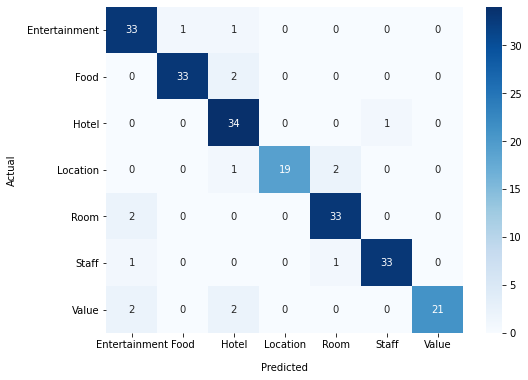

In [454]:
prediction(clf1,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [455]:
modnb1 = prediction.results
modnb1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.920928,0.939466,0.920928,0.92761,0.994054


### Logistic Regression

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.97      0.94      0.96        35
           2       0.94      0.91      0.93        35
           3       1.00      0.95      0.98        22
           4       0.97      0.94      0.96        35
           5       1.00      0.94      0.97        35
           6       1.00      0.84      0.91        25

    accuracy                           0.93       222
   macro avg       0.95      0.93      0.94       222
weighted avg       0.94      0.93      0.93       222



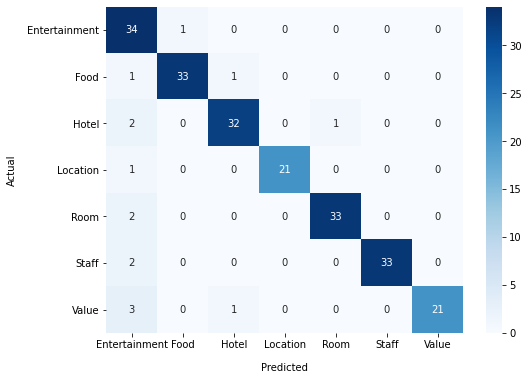

In [456]:
prediction(clf2,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [457]:
modlr1 = prediction.results
modlr1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.929833,0.948273,0.929833,0.935851,0.996128


In [458]:
# Save out for combined model
filename = 'best_model_accom.sav'
joblib.dump(clf2, filename)

['best_model_accom.sav']

### Random Forest

              precision    recall  f1-score   support

           0       0.71      0.97      0.82        35
           1       0.97      0.94      0.96        35
           2       0.97      0.91      0.94        35
           3       1.00      0.95      0.98        22
           4       1.00      0.91      0.96        35
           5       1.00      0.94      0.97        35
           6       1.00      0.84      0.91        25

    accuracy                           0.93       222
   macro avg       0.95      0.93      0.93       222
weighted avg       0.94      0.93      0.93       222



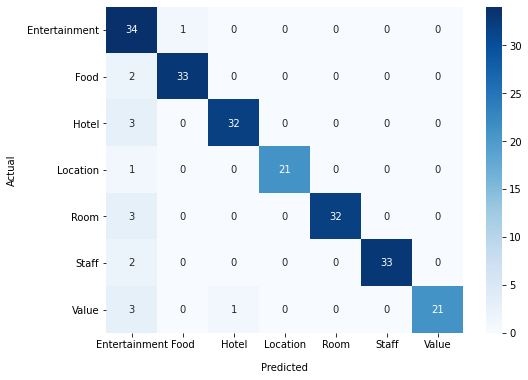

In [322]:
prediction(clf3,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [323]:
modrf1 = prediction.results
modrf1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.925751,0.949803,0.925751,0.933225,0.97091


### SVM

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        35
           1       0.97      0.91      0.94        35
           2       0.94      0.91      0.93        35
           3       1.00      0.95      0.98        22
           4       0.92      0.94      0.93        35
           5       0.97      0.94      0.96        35
           6       1.00      0.80      0.89        25

    accuracy                           0.93       222
   macro avg       0.94      0.92      0.93       222
weighted avg       0.94      0.93      0.93       222



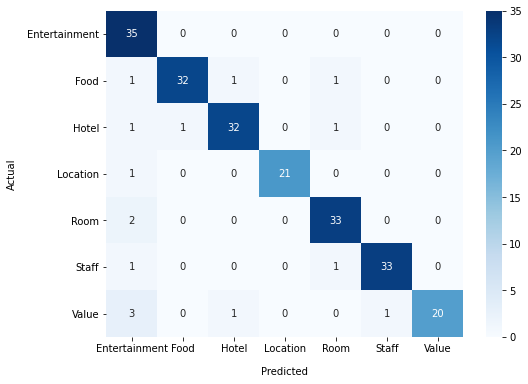

In [324]:
prediction(clf4,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [325]:
modsvm1 = prediction.results
modsvm1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.924119,0.94194,0.924119,0.929503,0.990383


## Food

### Multinomial NB

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        35
           1       0.91      0.83      0.87        35
           2       0.94      0.97      0.96        35
           3       0.97      0.97      0.97        35
           4       0.97      0.97      0.97        35
           5       0.89      0.91      0.90        35

    accuracy                           0.92       210
   macro avg       0.92      0.92      0.92       210
weighted avg       0.92      0.92      0.92       210



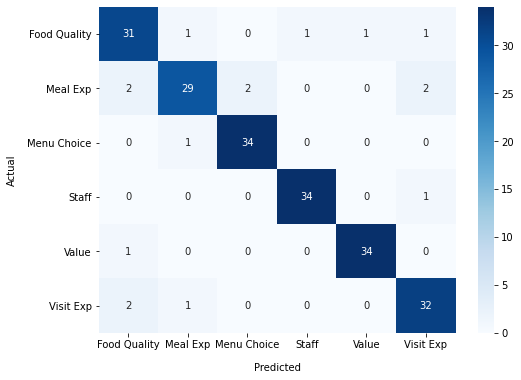

In [326]:
prediction(clf1,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [327]:
modnb2 = prediction.results
modnb2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.92381,0.923925,0.92381,0.923487,0.995102


### Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.81      0.97      0.88        35
           2       1.00      0.97      0.99        35
           3       0.97      1.00      0.99        35
           4       0.97      0.97      0.97        35
           5       0.97      0.80      0.88        35

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



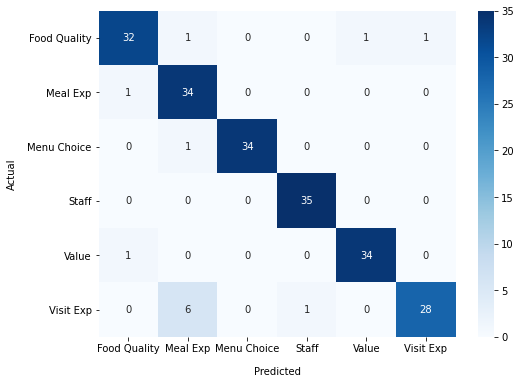

In [328]:
prediction(clf2,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [329]:
modlr2 = prediction.results
modlr2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.938095,0.943311,0.938095,0.938084,0.997605


### Random Forest

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.85      0.97      0.91        35
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        35
           5       0.97      0.83      0.89        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



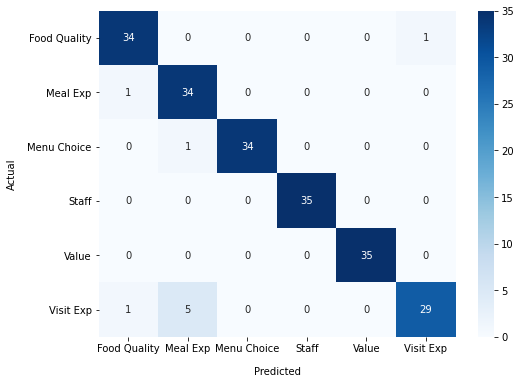

In [330]:
prediction(clf3,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [331]:
modrf2 = prediction.results
modrf2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.957143,0.960185,0.957143,0.957038,0.996571


### SVM

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.85      0.94      0.89        35
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        35
           4       0.97      1.00      0.99        35
           5       0.93      0.80      0.86        35

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



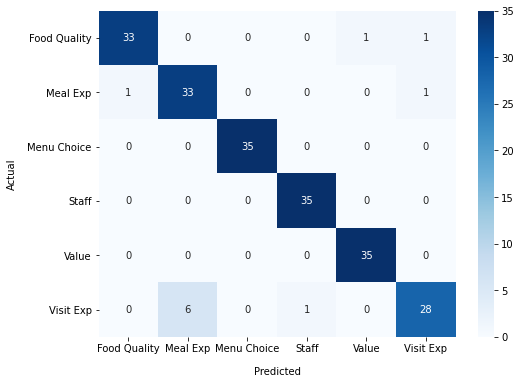

In [332]:
prediction(clf4,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [333]:
modsvm2 = prediction.results
modsvm2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.947619,0.949087,0.947619,0.946964,0.995483


## Attractions

### Multinomial NB

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        30
           1       0.80      0.93      0.86        30
           2       1.00      0.80      0.89        15
           3       0.92      0.73      0.81        30
           4       0.89      0.80      0.84        20
           5       0.92      0.73      0.81        15
           6       1.00      0.60      0.75        25

    accuracy                           0.81       165
   macro avg       0.88      0.80      0.82       165
weighted avg       0.86      0.81      0.81       165



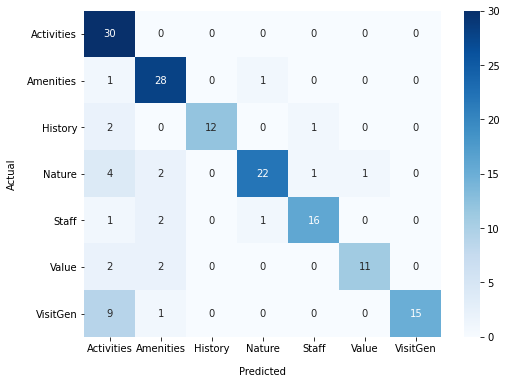

In [334]:
prediction(clf1,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [335]:
modnb3 = prediction.results
modnb3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.8,0.876352,0.8,0.818808,0.97446


### Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.87      0.90      0.89        30
           2       1.00      0.80      0.89        15
           3       0.95      0.67      0.78        30
           4       0.89      0.80      0.84        20
           5       0.87      0.87      0.87        15
           6       0.62      0.92      0.74        25

    accuracy                           0.85       165
   macro avg       0.88      0.85      0.85       165
weighted avg       0.87      0.85      0.85       165



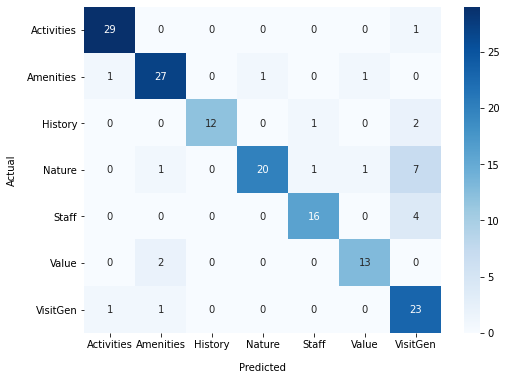

In [336]:
prediction(clf2,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [337]:
clf2.fit(X_train_attract_tfidf,y_train_attract_l)
filename = 'best_model_attract.sav'
joblib.dump(clf2, filename)

['best_model_attract.sav']

In [338]:
modlr3 = prediction.results
modlr3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.845714,0.876573,0.845714,0.851425,0.980487


### Random Forest

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        30
           1       0.89      0.83      0.86        30
           2       1.00      0.67      0.80        15
           3       0.95      0.67      0.78        30
           4       0.94      0.80      0.86        20
           5       0.93      0.93      0.93        15
           6       0.79      0.60      0.68        25

    accuracy                           0.79       165
   macro avg       0.86      0.79      0.80       165
weighted avg       0.84      0.79      0.79       165



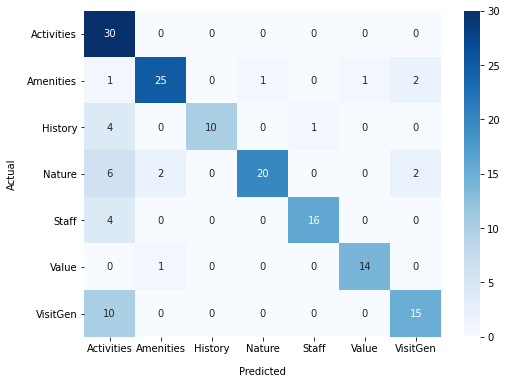

In [339]:
prediction(clf3,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [340]:
modrf3 = prediction.results
modrf3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.785714,0.864954,0.785714,0.804612,0.955349


### SVM

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        30
           1       0.84      0.87      0.85        30
           2       1.00      0.80      0.89        15
           3       0.91      0.67      0.77        30
           4       0.88      0.75      0.81        20
           5       0.86      0.80      0.83        15
           6       0.56      0.56      0.56        25

    accuracy                           0.78       165
   macro avg       0.82      0.78      0.79       165
weighted avg       0.80      0.78      0.78       165



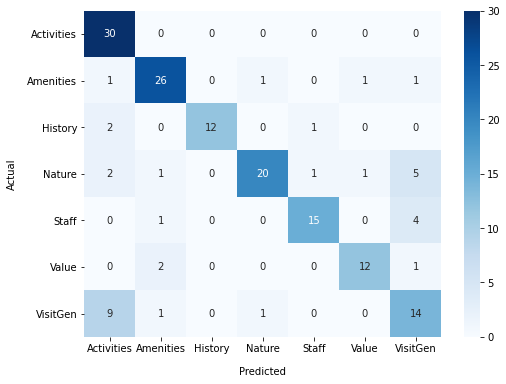

In [341]:
prediction(clf4,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [342]:
modsvm3 = prediction.results
modsvm3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.777619,0.818445,0.777619,0.788541,0.972611


# Section 5: Summary Tables

### Accommodation

In [451]:
accom = pd.concat([modnb1,modlr1,modrf1,modsvm1])
accom.index = ["Accom NB","Accom LR","Accom RF","Accom SVM"]
accom.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Accom LR,0.929833,0.948273,0.929833,0.935851,0.996128
Accom NB,0.920928,0.939466,0.920928,0.927610,0.994054
Accom SVM,0.924119,0.941940,0.924119,0.929503,0.990383
Accom RF,0.925751,0.949803,0.925751,0.933225,0.970910


In [449]:
accom = pd.concat([modnb1,modlr1,modrf1,modsvm1])
accom.index = ["Accom NB","Accom LR","Accom RF","Accom SVM"]
accom.sort_values(by = "F1",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Accom LR,0.929833,0.948273,0.929833,0.935851,0.996128
Accom RF,0.925751,0.949803,0.925751,0.933225,0.970910
Accom SVM,0.924119,0.941940,0.924119,0.929503,0.990383
Accom NB,0.920928,0.939466,0.920928,0.927610,0.994054


### Food

In [450]:
food = pd.concat([modnb2,modlr2,modrf2,modsvm2])
food.index = ["Food NB","Food LR","Food RF","Food SVM"]
food.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food LR,0.938095,0.943311,0.938095,0.938084,0.997605
Food RF,0.957143,0.960185,0.957143,0.957038,0.996571
Food SVM,0.947619,0.949087,0.947619,0.946964,0.995483
Food NB,0.923810,0.923925,0.923810,0.923487,0.995102


In [407]:
food = pd.concat([modnb2,modlr2,modrf2,modsvm2])
food.index = ["Food NB","Food LR","Food RF","Food SVM"]
food.sort_values(by = "F1",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food RF,0.957143,0.960185,0.957143,0.957038,0.996571
Food SVM,0.947619,0.949087,0.947619,0.946964,0.995483
Food LR,0.938095,0.943311,0.938095,0.938084,0.997605
Food NB,0.923810,0.923925,0.923810,0.923487,0.995102


### Attractions

In [408]:
attract = pd.concat([modnb3,modlr3,modrf3,modsvm3])
attract.index = ["Attract NB","Attract LR","Attract RF","Attract SVM"]
attract.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Attract LR,0.845714,0.876573,0.845714,0.851425,0.980487
Attract NB,0.800000,0.876352,0.800000,0.818808,0.974460
Attract SVM,0.777619,0.818445,0.777619,0.788541,0.972611
Attract RF,0.785714,0.864954,0.785714,0.804612,0.955349


In [409]:
attract = pd.concat([modnb3,modlr3,modrf3,modsvm3])
attract.index = ["Attract NB","Attract LR","Attract RF","Attract SVM"]
attract.sort_values(by = "F1",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Attract LR,0.845714,0.876573,0.845714,0.851425,0.980487
Attract NB,0.800000,0.876352,0.800000,0.818808,0.974460
Attract RF,0.785714,0.864954,0.785714,0.804612,0.955349
Attract SVM,0.777619,0.818445,0.777619,0.788541,0.972611


# Section 6: Hyperparameter Tuning 

In [402]:
print(sorted(SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [349]:
warnings.filterwarnings('ignore') 

In [419]:
best_model = LogisticRegression(class_weight = "balanced")
best_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [475]:
# Note scoring matches original scoring of auroc one verus one weighted
parameters = {'C': [0.001,0.01,0.1,1,10,100], 'penalty': ['none', 'l1', 'l2', 'elasticnet'],'solver': ['newton-cg', 'lbfgs', 'sag','saga']}
clf = GridSearchCV(best_model,param_grid=parameters, cv = 10, scoring = 'roc_auc_ovo_weighted')

### Accommodation

In [476]:
clf.fit(X_train_accom_tfidf,y_train_accom)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovo_weighted')

In [477]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.9961438664951581
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='saga')




In [478]:
# Set up the best model
best_model_accom = LogisticRegression(class_weight = "balanced",C=10, penalty = 'l2', solver = 'saga')

              precision    recall  f1-score   support

           0       0.79      0.97      0.87        35
           1       0.94      0.97      0.96        35
           2       0.97      0.91      0.94        35
           3       1.00      0.91      0.95        22
           4       0.92      0.94      0.93        35
           5       1.00      0.94      0.97        35
           6       1.00      0.84      0.91        25

    accuracy                           0.93       222
   macro avg       0.95      0.93      0.93       222
weighted avg       0.94      0.93      0.93       222



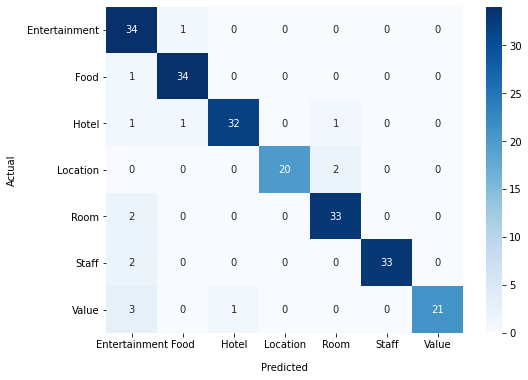

In [479]:
prediction(best_model_accom,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [480]:
modlrah = prediction.results
modlrah.index = ["Accommodation LR"]
modlrah

,Accuracy,Precision,Recall,F1,ROCAUC
Accommodation LR,0.927421,0.945929,0.927421,0.933758,0.996571


### Food

In [412]:
#best_model2 = RandomForestClassifier(class_weight = "balanced")
#best_model2.get_params().keys()
#parameters = {"max_depth":[2, 8, 16],"n_estimators":[10,100,1000], "max_features":range(1,21,1)}
#clfb2 = GridSearchCV(best_model2,param_grid=parameters, cv = 10, scoring = 'f1_macro')

In [483]:
clf.fit(X_train_food_tfidf, y_train_food)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovo_weighted')

In [484]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.9970365646258506
Best estimator: LogisticRegression(C=1, class_weight='balanced', solver='newton-cg')




In [485]:
# Set up the best model
best_model_food = LogisticRegression(class_weight = "balanced",C=1, penalty = 'l2', solver = 'newton-cg')

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.81      0.97      0.88        35
           2       1.00      0.97      0.99        35
           3       0.97      1.00      0.99        35
           4       0.97      0.97      0.97        35
           5       0.97      0.80      0.88        35

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



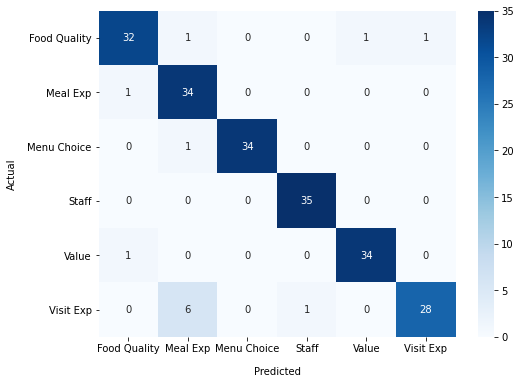

In [486]:
prediction(best_model_food,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

No improvement from tuning

In [487]:
modlrfh = prediction.results
modlrfh.index = ["Food RF"]
modlrfh

,Accuracy,Precision,Recall,F1,ROCAUC
Food RF,0.938095,0.943311,0.938095,0.938084,0.997605


### Attractions

In [488]:
clf.fit(X_train_attract_tfidf, y_train_attract)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovo_weighted')

In [489]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.9796212121212123
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='saga')




In [490]:
# Set up the best model
best_model_attract = LogisticRegression(class_weight = "balanced",C=10, penalty = 'l2', solver = 'saga')

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.90      0.90      0.90        30
           2       1.00      0.80      0.89        15
           3       0.92      0.73      0.81        30
           4       0.89      0.85      0.87        20
           5       0.88      0.93      0.90        15
           6       0.72      0.92      0.81        25

    accuracy                           0.87       165
   macro avg       0.89      0.87      0.87       165
weighted avg       0.88      0.87      0.87       165



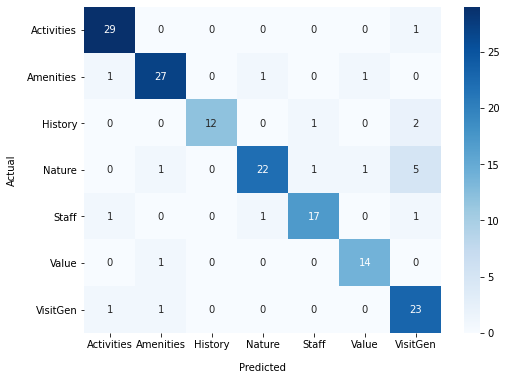

In [491]:
prediction(best_model_attract,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

Slight improvement from tuning

In [492]:
modlath = prediction.results
modlath.index = ["Attractions LR"]
modlath

,Accuracy,Precision,Recall,F1,ROCAUC
Attractions LR,0.871905,0.887343,0.871905,0.874461,0.98195


In [494]:
hyp = pd.concat([modlrah, modlrfh, modlath])
hyp.index = ["Accom LR Hyp","Food LR Hyp","Attract LR Hyp"]
hyp

,Accuracy,Precision,Recall,F1,ROCAUC
Accom LR Hyp,0.927421,0.945929,0.927421,0.933758,0.996571
Food LR Hyp,0.938095,0.943311,0.938095,0.938084,0.997605
Attract LR Hyp,0.871905,0.887343,0.871905,0.874461,0.981950


# Section 7: Best Model Against Test Set

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.95      1.00      0.97        35
           2       1.00      0.97      0.99        35
           3       1.00      0.95      0.98        22
           4       0.94      0.89      0.91        35
           5       1.00      0.94      0.97        35
           6       1.00      0.96      0.98        25

    accuracy                           0.95       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.95      0.96       222



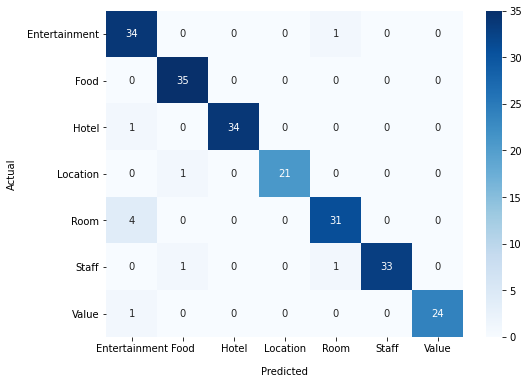

In [495]:
# Hyperparameter tuned model is best model for accommodation
prediction(best_model_accom,X_train_accom_tfidf,y_train_accom_l,X_test_accom_tfidf,y_test_accom_l,labels_accom)

In [496]:
modtestaccom = prediction.results
modtestaccom.index = ["Accommodation Best Model (Test)"]
modtestaccom

,Accuracy,Precision,Recall,F1,ROCAUC
Accommodation Best Model (Test),0.955139,0.962191,0.955139,0.957584,0.997987


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       0.92      1.00      0.96        35
           2       1.00      0.97      0.99        35
           3       0.97      1.00      0.99        35
           4       0.97      0.97      0.97        35
           5       1.00      0.89      0.94        35

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



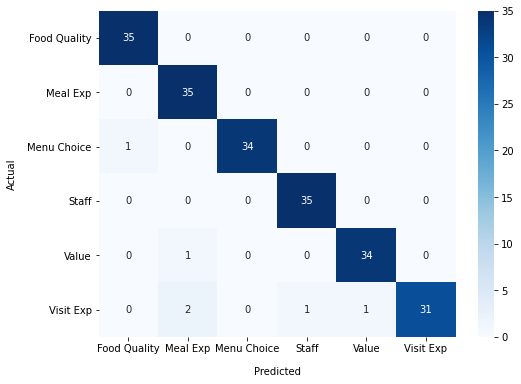

In [497]:
prediction(best_model_food,X_train_food_tfidf,y_train_food_l,X_test_food_tfidf,y_test_food_l,labels_food)

In [498]:
modtestfood = prediction.results
modtestfood.index = ["Food"]
modtestfood

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.971429,0.972821,0.971429,0.971177,0.997007


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.89      0.83      0.86        30
           2       0.86      0.80      0.83        15
           3       0.96      0.87      0.91        30
           4       0.86      0.95      0.90        20
           5       1.00      0.87      0.93        15
           6       0.59      0.80      0.68        25

    accuracy                           0.84       165
   macro avg       0.86      0.85      0.85       165
weighted avg       0.86      0.84      0.85       165



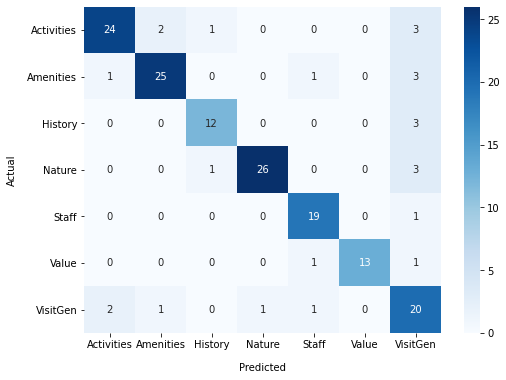

In [499]:
prediction(best_model_attract,X_train_attract_tfidf,y_train_attract_l,X_test_attract_tfidf,y_test_attract_l,labels_attract)

In [500]:
modtestattract = prediction.results
modtestattract.index = ["Attract"]
modtestattract

,Accuracy,Precision,Recall,F1,ROCAUC
Attract,0.845238,0.864818,0.845238,0.850763,0.975754


In [501]:
test = pd.concat([modtestaccom, modtestfood,modtestattract])
test.index = ["Accom Test","Food Test","Attract Test"]
test

,Accuracy,Precision,Recall,F1,ROCAUC
Accom Test,0.955139,0.962191,0.955139,0.957584,0.997987
Food Test,0.971429,0.972821,0.971429,0.971177,0.997007
Attract Test,0.845238,0.864818,0.845238,0.850763,0.975754
